<a href="https://colab.research.google.com/github/Dr-jchai/amorphous_graphene/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pymatgen networkx matplotlib ase

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 496.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.1/754.1 kB 38.6 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=ae3d898a29c474a0e68d8a57382bf275ff7f2dbe0b28dbb43fd488422d56ad68
  Stored in directory: /root/.cache/pip/wheels/1f/7d/e9/1ff2509f13767a55df1279744ad

读取POSCAR文件...
原子数量: 112
晶格参数:
  a: [ 17.2566,   0.0000,   0.0000]
  b: [  0.0009,  17.2781,   0.0000]
  c: [  0.0000,   0.0000,  15.0000]
计算原子间距离并建立连接...
  进度: 19.7% (50/112 原子)
  进度: 79.6% (100/112 原子)
  进度: 100.0% (112/112 原子)
建立了 167 个连接
平均每个原子的配位数: 2.98
开始全面环检测（包括非凸环）...
  环检测进度: 0.0% (0/112 节点)
  环检测进度: 17.9% (20/112 节点)
  环检测进度: 35.7% (40/112 节点)
  环检测进度: 53.6% (60/112 节点)
  环检测进度: 71.4% (80/112 节点)
  环检测进度: 89.3% (100/112 节点)
  初步检测到 145 个唯一环
  补充检测基础环...
  补充后总共 177 个环
环检测阶段完成，耗时: 2.50秒
简化版环去重检测（1%阈值）...
  去重进度: 28.2% (50/177)
  去重进度: 56.5% (100/177)
  去重进度: 84.7% (150/177)
  原始环数: 177
  去重后环数: 56
  去除了 121 个重叠环
  各尺寸环去重详情:
    4元环: 2 → 1 (去除1个, 50.0%)
    5元环: 15 → 15 (去除0个, 0.0%)
    6元环: 50 → 26 (去除24个, 48.0%)
    7元环: 9 → 8 (去除1个, 11.1%)
    8元环: 13 → 5 (去除8个, 61.5%)
    9元环: 41 → 1 (去除40个, 97.6%)
    10元环: 47 → 0 (去除47个, 100.0%)
简化去重后的环尺寸分布:
  4元环: 1 个
  5元环: 15 个
  6元环: 26 个
  7元环: 8 个
  8元环: 5 个
  9元环: 1 个
非晶石墨烯环分布统计（简化版：1%重叠阈值）
总原子数: 112
总化学键数: 167
唯一环数: 56
平均每原子配位数: 2.

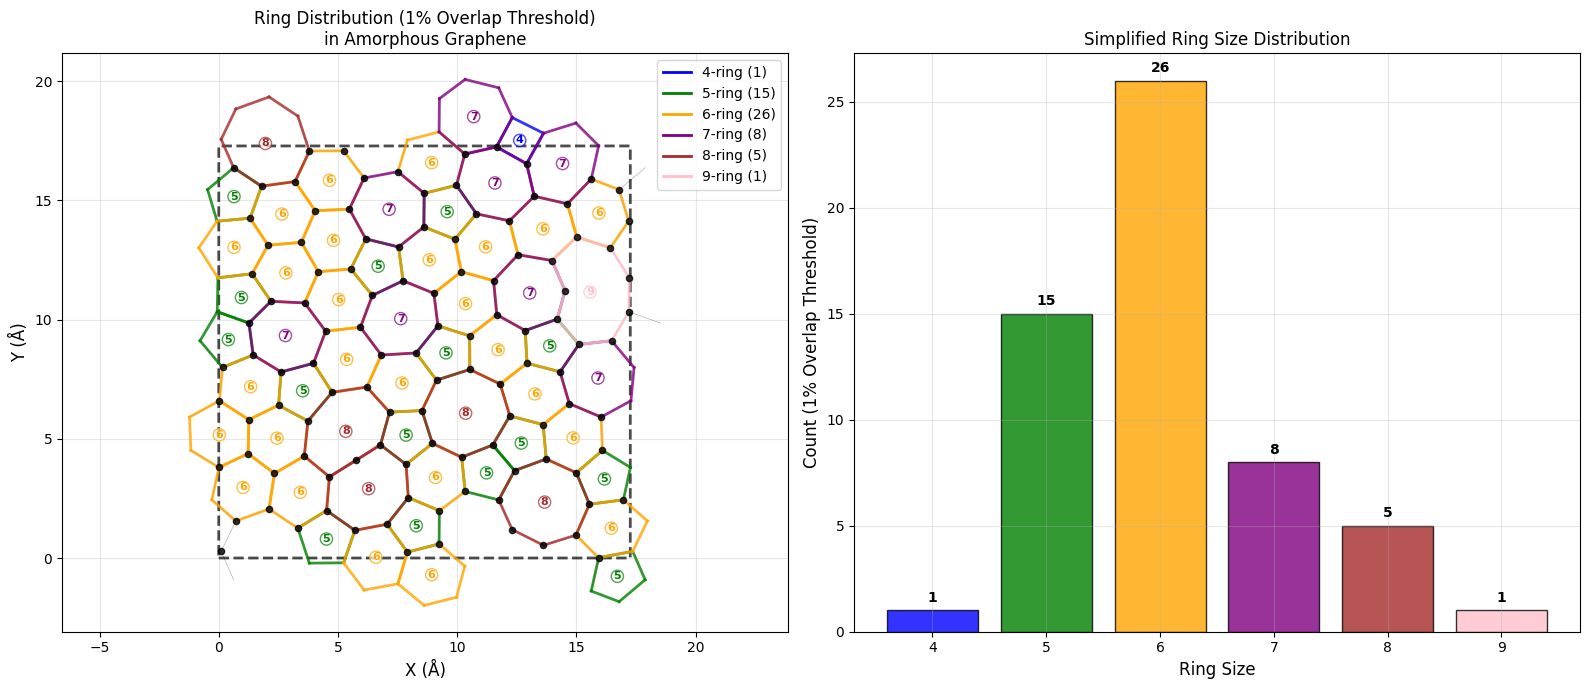

[OK] 环分布图已保存到: /content/rings.png

总耗时: 6.73秒


In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
快速统计非晶石墨烯中的多边形环 (简化版去重算法)
针对非晶石墨烯优化，C-C键长cutoff=1.6
使用简单的1%覆盖阈值避免环重复统计
"""
import networkx as nx
import matplotlib.pyplot as plt
from pymatgen.io.vasp import Poscar
from collections import Counter, defaultdict
import numpy as np
import time
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
from shapely.errors import TopologicalError

def find_minimum_distance_with_pbc(coord1, coord2, lattice_matrix):
    """
    计算两个原子在周期性边界条件下的最短距离和对应的坐标
    """
    min_dist = float('inf')
    best_coord2 = coord2.copy()

    # 检查27个周期性镜像 (-1,-1,-1) 到 (1,1,1)
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            for dz in [-1, 0, 1]:
                offset = dx * lattice_matrix[0] + dy * lattice_matrix[1] + dz * lattice_matrix[2]
                shifted_coord2 = coord2 + offset
                dist = np.linalg.norm(coord1 - shifted_coord2)

                if dist < min_dist:
                    min_dist = dist
                    best_coord2 = shifted_coord2

    return min_dist, best_coord2

def build_fast_periodic_graph(poscar_file="/content/POSCAR", cutoff=1.6):
    """
    构建图并处理周期性边界条件
    """
    print("读取POSCAR文件...")
    poscar = Poscar.from_file(poscar_file)
    structure = poscar.structure
    n_atoms = len(structure)

    # 获取晶格参数
    lattice_matrix = structure.lattice.matrix

    print(f"原子数量: {n_atoms}")
    print(f"晶格参数:")
    for i, vec in enumerate(lattice_matrix):
        print(f"  {['a', 'b', 'c'][i]}: [{vec[0]:8.4f}, {vec[1]:8.4f}, {vec[2]:8.4f}]")

    # 获取原子坐标
    original_coords = np.array([site.coords for site in structure])

    # 创建图和存储实际绘图坐标
    G = nx.Graph()
    plot_coords = original_coords.copy()  # 用于绘图的坐标
    edge_coords = {}  # 存储每条边对应的实际坐标

    for i in range(n_atoms):
        G.add_node(i)

    print("计算原子间距离并建立连接...")

    edges_added = 0
    total_pairs = n_atoms * (n_atoms - 1) // 2

    for i in range(n_atoms):
        for j in range(i+1, n_atoms):
            # 计算在周期性边界条件下的最短距离
            min_dist, best_j_coord = find_minimum_distance_with_pbc(
                original_coords[i], original_coords[j], lattice_matrix)

            if min_dist < cutoff:
                G.add_edge(i, j)
                # 存储用于绘图的坐标对
                edge_coords[(i, j)] = (original_coords[i], best_j_coord)
                edges_added += 1

        # 进度显示
        if (i + 1) % 50 == 0 or i == n_atoms - 1:
            progress = ((i + 1) * i // 2) / total_pairs * 100
            print(f"  进度: {progress:.1f}% ({i+1}/{n_atoms} 原子)")

    print(f"建立了 {edges_added} 个连接")
    print(f"平均每个原子的配位数: {2*edges_added/n_atoms:.2f}")

    return G, original_coords, edge_coords, structure, lattice_matrix

def adjust_ring_coordinates(cycle, original_coords, lattice_matrix):
    """
    调整环中原子的坐标，使跨边界的环显示在一起
    """
    if len(cycle) < 3:
        return original_coords[cycle]

    adjusted_coords = [original_coords[cycle[0]]]  # 第一个原子作为参考

    for i in range(1, len(cycle)):
        prev_coord = adjusted_coords[i-1]
        current_original = original_coords[cycle[i]]

        # 找到与前一个原子最近的周期性镜像位置
        _, best_coord = find_minimum_distance_with_pbc(
            prev_coord, current_original, lattice_matrix)
        adjusted_coords.append(best_coord)

    return np.array(adjusted_coords)

def find_all_cycles_dfs(G, start_node, max_length):
    """
    使用深度优先搜索找到从指定节点开始的所有环
    """
    all_cycles = []

    def dfs(current_path, visited_edges):
        if len(current_path) > max_length:
            return

        current_node = current_path[-1]

        # 检查是否能回到起始点形成环
        if len(current_path) >= 3 and start_node in G.neighbors(current_node):
            edge_key = tuple(sorted([current_node, start_node]))
            if edge_key not in visited_edges:
                # 找到一个新环
                cycle = current_path[:]
                all_cycles.append(cycle)

        # 如果路径还不够长，继续搜索
        if len(current_path) < max_length:
            for neighbor in G.neighbors(current_node):
                edge_key = tuple(sorted([current_node, neighbor]))

                # 避免立即返回前一个节点（除非形成小环）
                if len(current_path) >= 2 and neighbor == current_path[-2] and len(current_path) < 3:
                    continue

                # 避免重复使用边
                if edge_key in visited_edges:
                    continue

                # 避免重复访问节点（但允许回到起始点）
                if neighbor in current_path[1:] and neighbor != start_node:
                    continue

                new_visited_edges = visited_edges.copy()
                new_visited_edges.add(edge_key)
                dfs(current_path + [neighbor], new_visited_edges)

    dfs([start_node], set())
    return all_cycles

def is_ring_region_already_covered(cycle, original_coords, lattice_matrix, occupied_regions, coverage_threshold=0.01):
    """
    简化版：检查环的区域是否已被其他环覆盖超过1%
    """
    try:
        ring_coords = adjust_ring_coordinates(cycle, original_coords, lattice_matrix)
        ring_polygon = Polygon(ring_coords[:, :2])

        if not ring_polygon.is_valid:
            ring_polygon = ring_polygon.buffer(0)

        if ring_polygon.is_empty:
            return True

        original_area = ring_polygon.area
        if original_area <= 1e-10:  # 面积太小
            return True

        # 计算被已有区域覆盖的面积
        covered_area = 0.0
        for occupied_region in occupied_regions:
            try:
                if ring_polygon.intersects(occupied_region):
                    intersection = ring_polygon.intersection(occupied_region)
                    if hasattr(intersection, 'area'):
                        covered_area += intersection.area
            except (TopologicalError, ValueError):
                continue

        # 如果覆盖比例超过1%，就认为该区域已被占用
        coverage_ratio = covered_area / original_area
        return coverage_ratio > coverage_threshold

    except (ValueError, TopologicalError):
        return True

def remove_overlapping_rings_simple(cycles, original_coords, lattice_matrix):
    """
    简化版环去重：只要有1%重叠就跳过
    """
    print("简化版环去重检测（1%阈值）...")

    if not cycles:
        return []

    # 按环大小排序，优先处理小环
    cycles_with_size = [(cycle, len(cycle)) for cycle in cycles]
    cycles_with_size.sort(key=lambda x: x[1])

    selected_rings = []
    occupied_regions = []  # 存储已占用的区域
    total_cycles = len(cycles_with_size)
    processed = 0

    for current_cycle, current_size in cycles_with_size:
        processed += 1
        if processed % 50 == 0:
            progress = processed / total_cycles * 100
            print(f"  去重进度: {progress:.1f}% ({processed}/{total_cycles})")

        # 简单检查：只要有1%重叠就跳过
        if is_ring_region_already_covered(current_cycle, original_coords, lattice_matrix, occupied_regions, coverage_threshold=0.01):
            continue  # 跳过有重叠的环

        # 通过检查，添加到选中列表
        selected_rings.append(current_cycle)

        # 将当前环的区域添加到已占用列表
        try:
            ring_coords = adjust_ring_coordinates(current_cycle, original_coords, lattice_matrix)
            ring_polygon = Polygon(ring_coords[:, :2])
            if not ring_polygon.is_valid:
                ring_polygon = ring_polygon.buffer(0)
            if not ring_polygon.is_empty:
                occupied_regions.append(ring_polygon)
        except (ValueError, TopologicalError):
            pass

    print(f"  原始环数: {len(cycles)}")
    print(f"  去重后环数: {len(selected_rings)}")
    print(f"  去除了 {len(cycles) - len(selected_rings)} 个重叠环")

    # 打印各尺寸环的去重统计
    original_counter = Counter([len(c) for c in cycles])
    final_counter = Counter([len(c) for c in selected_rings])

    print("  各尺寸环去重详情:")
    for size in sorted(original_counter.keys()):
        original_count = original_counter[size]
        final_count = final_counter.get(size, 0)
        removed_count = original_count - final_count
        removal_rate = (removed_count / original_count * 100) if original_count > 0 else 0
        print(f"    {size}元环: {original_count} → {final_count} (去除{removed_count}个, {removal_rate:.1f}%)")

    return selected_rings

def find_rings_comprehensive(G, max_ring_size=10):
    """
    全面的环检测算法，包括去重处理
    """
    print("开始全面环检测（包括非凸环）...")
    start_time = time.time()

    all_unique_cycles = []
    processed_cycle_signatures = set()

    # 为了避免重复，我们从度数较小的节点开始搜索
    nodes_by_degree = sorted(G.nodes(), key=lambda x: G.degree(x))

    total_nodes = len(nodes_by_degree)

    for idx, start_node in enumerate(nodes_by_degree):
        if idx % 20 == 0:
            progress = idx / total_nodes * 100
            print(f"  环检测进度: {progress:.1f}% ({idx}/{total_nodes} 节点)")

        # 从这个节点开始找所有环
        cycles_from_node = find_all_cycles_dfs(G, start_node, max_ring_size)

        for cycle in cycles_from_node:
            if len(cycle) > max_ring_size:
                continue

            # 创建环的标准化签名以避免重复
            min_node = min(cycle)
            min_idx = cycle.index(min_node)

            # 正向标准化
            normalized_forward = tuple(cycle[min_idx:] + cycle[:min_idx])
            # 反向标准化
            reversed_cycle = cycle[::-1]
            min_idx_rev = reversed_cycle.index(min_node)
            normalized_reverse = tuple(reversed_cycle[min_idx_rev:] + reversed_cycle[:min_idx_rev])

            # 选择字典序较小的作为标准形式
            signature = min(normalized_forward, normalized_reverse)

            if signature not in processed_cycle_signatures:
                processed_cycle_signatures.add(signature)
                all_unique_cycles.append(cycle)

    print(f"  初步检测到 {len(all_unique_cycles)} 个唯一环")

    # 尝试补充使用networkx的方法找到可能遗漏的环
    try:
        print("  补充检测基础环...")
        basis_cycles = nx.minimum_cycle_basis(G)

        for cycle in basis_cycles:
            if len(cycle) <= max_ring_size:
                min_node = min(cycle)
                min_idx = cycle.index(min_node)
                normalized = tuple(cycle[min_idx:] + cycle[:min_idx])

                # 检查是否已经找到这个环
                found = False
                for existing_cycle in all_unique_cycles:
                    existing_min = min(existing_cycle)
                    existing_min_idx = existing_cycle.index(existing_min)
                    existing_normalized = tuple(existing_cycle[existing_min_idx:] + existing_cycle[:existing_min_idx])

                    if normalized == existing_normalized:
                        found = True
                        break

                if not found:
                    all_unique_cycles.append(cycle)

        print(f"  补充后总共 {len(all_unique_cycles)} 个环")

    except Exception as e:
        print(f"  补充检测失败: {e}")

    elapsed_time = time.time() - start_time
    print(f"环检测阶段完成，耗时: {elapsed_time:.2f}秒")

    return all_unique_cycles

def analyze_unique_rings(G, original_coords, lattice_matrix, max_ring_size=10):
    """
    分析唯一的环，使用简化版去重算法
    """
    # 首先找到所有可能的环
    all_cycles = find_rings_comprehensive(G, max_ring_size)

    # 使用简化版去重（1%阈值）
    unique_cycles = remove_overlapping_rings_simple(all_cycles, original_coords, lattice_matrix)

    # 统计环尺寸
    ring_sizes = [len(c) for c in unique_cycles]
    ring_counter = Counter(ring_sizes)

    # 详细统计信息
    print("简化去重后的环尺寸分布:")
    for size in sorted(ring_counter.keys()):
        print(f"  {size}元环: {ring_counter[size]} 个")

    return ring_counter, unique_cycles

def plot_rings_fast(original_coords, edge_coords, cycles, ring_counter,
                   lattice_matrix, outfile="/content/rings.png"):
    """
    绘制环分布图，正确处理周期性边界
    """
    print("绘制环分布图...")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # 左图：结构图with环标注
    # 绘制原子
    ax1.scatter(original_coords[:,0], original_coords[:,1],
               c="black", s=20, alpha=0.8, zorder=5)

    # 绘制所有的键
    print("绘制化学键...")
    for (i, j), (coord_i, coord_j) in edge_coords.items():
        ax1.plot([coord_i[0], coord_j[0]], [coord_i[1], coord_j[1]],
                'gray', linewidth=0.5, alpha=0.6, zorder=1)

    # 环颜色映射
    colors = {3:"red", 4:"blue", 5:"green", 6:"orange", 7:"purple", 8:"brown", 9:"pink", 10:"cyan"}

    # 绘制环
    print("绘制环结构...")
    ring_counts = defaultdict(int)
    max_rings_per_type = 100  # 显示更多环

    for cycle in cycles:
        ring_size = len(cycle)
        if ring_size in colors and ring_counts[ring_size] < max_rings_per_type:
            # 调整环坐标使其连续显示
            ring_coords = adjust_ring_coordinates(cycle, original_coords, lattice_matrix)

            # 绘制环的边界
            for i in range(len(cycle)):
                j = (i + 1) % len(cycle)
                ax1.plot([ring_coords[i,0], ring_coords[j,0]],
                        [ring_coords[i,1], ring_coords[j,1]],
                        c=colors[ring_size], lw=2, alpha=0.8, zorder=3)

            # 在重心标注环大小
            center = ring_coords.mean(axis=0)
            ax1.text(center[0], center[1], str(ring_size),
                    color=colors[ring_size], ha="center", va="center",
                    fontsize=8, fontweight="bold", zorder=4,
                    bbox=dict(boxstyle="circle,pad=0.1", facecolor="white",
                             alpha=0.7, edgecolor=colors[ring_size]))

            ring_counts[ring_size] += 1

    # 绘制晶胞边界
    lattice_2d = lattice_matrix[:2, :2]  # 取2D部分
    origin = [0, 0]
    corners = [
        origin,
        lattice_2d[0],
        lattice_2d[0] + lattice_2d[1],
        lattice_2d[1],
        origin
    ]
    corners = np.array(corners)
    ax1.plot(corners[:, 0], corners[:, 1], 'k--', linewidth=2, alpha=0.7, zorder=2)

    ax1.set_xlabel('X (Å)', fontsize=12)
    ax1.set_ylabel('Y (Å)', fontsize=12)
    ax1.set_title('Ring Distribution (1% Overlap Threshold)\nin Amorphous Graphene', fontsize=12)
    ax1.axis("equal")
    ax1.grid(True, alpha=0.3)

    # 添加图例
    legend_elements = []
    for ring_size in sorted(colors.keys()):
        if ring_size in ring_counter:
            legend_elements.append(plt.Line2D([0], [0], color=colors[ring_size],
                                            lw=2, label=f'{ring_size}-ring ({ring_counter[ring_size]})'))
    if legend_elements:
        ax1.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))

    # 右图：统计柱状图
    if ring_counter:
        ring_sizes = sorted(ring_counter.keys())
        counts = [ring_counter[size] for size in ring_sizes]

        bars = ax2.bar(ring_sizes, counts,
                      color=[colors.get(size, 'gray') for size in ring_sizes],
                      alpha=0.8, edgecolor='black', linewidth=1)

        # 在柱子上显示数值
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                    f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=10)

        ax2.set_xlabel('Ring Size', fontsize=12)
        ax2.set_ylabel('Count (1% Overlap Threshold)', fontsize=12)
        ax2.set_title('Simplified Ring Size Distribution', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.set_xticks(ring_sizes)

    plt.tight_layout()
    plt.savefig(outfile, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"[OK] 环分布图已保存到: {outfile}")

def print_statistics(ring_counter, total_atoms, total_edges):
    """
    打印详细统计信息
    """
    print("=" * 60)
    print("非晶石墨烯环分布统计（简化版：1%重叠阈值）")
    print("=" * 60)

    total_rings = sum(ring_counter.values())

    print(f"总原子数: {total_atoms}")
    print(f"总化学键数: {total_edges}")
    print(f"唯一环数: {total_rings}")
    print(f"平均每原子配位数: {2*total_edges/total_atoms:.2f}")
    print(f"平均每原子唯一环数: {total_rings/total_atoms:.2f}")
    print()

    print("唯一环尺寸分布:")
    print("-" * 30)
    for ring_size in sorted(ring_counter.keys()):
        count = ring_counter[ring_size]
        percentage = (count / total_rings) * 100 if total_rings > 0 else 0
        print(f"{ring_size:2d}-环: {count:4d} 个 ({percentage:5.1f}%)")

    print("=" * 60)
    print("注意：使用1%重叠阈值，任何有重叠的环都不重复统计")

if __name__ == "__main__":
    poscar_file = "/content/POSCAR"

    start_total = time.time()

    try:
        # 检查是否安装了shapely
        try:
            import shapely
        except ImportError:
            print("警告: 未安装shapely库，将安装...")
            import subprocess
            subprocess.check_call(['pip', 'install', 'shapely'])
            import shapely

        # 构建图
        G, coords, edge_coords, structure, lattice_matrix = build_fast_periodic_graph(
            poscar_file, cutoff=1.6)

        # 分析唯一环 - 使用简化的1%阈值去重方法
        ring_counter, unique_cycles = analyze_unique_rings(G, coords, lattice_matrix, max_ring_size=10)

        # 打印统计信息
        print_statistics(ring_counter, len(structure), G.number_of_edges())

        # 绘制结果
        plot_rings_fast(coords, edge_coords, unique_cycles, ring_counter,
                       lattice_matrix)

        total_time = time.time() - start_total
        print(f"\n总耗时: {total_time:.2f}秒")

    except Exception as e:
        print(f"错误: {e}")
        import traceback
        traceback.print_exc()